# The Dynamic Factor Model


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import metran

metran.show_versions()

Python version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.2
scipy version: 1.5.2
pandas version: 1.2.0
matplotlib version: 3.3.2
pastas version: 0.16.0
numba version: 0.51.2
lmfit version: 1.0.2


<div class="alert alert-block alert-info">
<b>Tip:</b> To run this notebook and the related metran model, it is strongly recommended to install Numba (http://numba.pydata.org). This Just-In-Time (JIT) compiler compiles the computationally intensive part of metran model.
</div>

When modeling multiple groundwater time series within the same hydrological system, it often appears that these components show distinct correlations between locations. Usually large part of the correlation is caused by common input stresses like precipitation and evapotranspiration, which shows up within the deterministic components of the models.

The residual components of the univariate TFN models are often correlated as well. This means that there is spatial correlation
which has not been captured by the deterministic component, e.g. because of errors in common input data or due to simplification of the hydrological model leading to misspecification of the deterministic component. We can exploit these correlations by modeling the series simultaneously with a dynamic factor model. Dynamic factor modeling (DFM) is a multivariate timeseries analysis technique used to describe the variation among many variables in terms of a few underlying but unobserved variables called factors.

This notebook explains the Dynamic Factor Model (DFM) as presented in [Berendrecht and Van Geer, 2016](#References). It describes the model, model parameters and how the results may be interpreted.

## 1. Basic multivariate AR(1) model
A general univariate AR(1) model can be written as:

$$ 
\begin{align}
 {x}_t&=\phi x_{t-1}+\eta_t\\
 {n}_t&={x}_t+\varepsilon_t
\end{align}
$$

with $\phi$ the AR(1) parameter, $\eta_t$ a zero mean white noise process, and $\varepsilon_t$ the measurement noise. In the current version of `metran` the measurement noise is assumed to be zero, so that $n_t=x_t$.

The multivariate extension of this model is:

$$ 
 \left[\begin{array}{c}x_{1}\\x_{2}\end{array}\right]_t = \left[\begin{array}{cc}\phi_{1} & 0\\0 & \phi_{2}\end{array}\right] \left[\begin{array}{c}x_{1}\\x_{2}\end{array}\right]_{t-1} + \left[\begin{array}{c}\eta_{1}\\\eta_{2}\end{array}\right]_t
$$

Or:

$$ 
 \mathbf{x}_t=\mathbf{\Phi} \mathbf{x}_{t-1}+\mathbf{\eta}_t
$$

## 2. Generate synthetic correlated time series
Let us generate time series based on the 2-dimensional model given above. We use the AR(1) model to generate three time series with the AR(1) parameter $\phi$: two series as the specific dynamic factor and one series as the common dynamic factor. Combining the specific and common dynamic factors results in two time series which are mutually correlated.

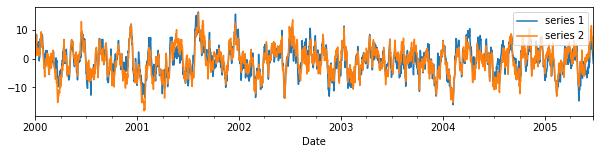

In [2]:
# seed numpy.random
np.random.seed(20210505)

# define mean and scale (standard deviation for noise series)
mean = np.zeros(3)
scale=[1, 0.6, 2]

# generate noise series that are mutually uncorrelated
noise = np.random.multivariate_normal(mean, np.diag(np.square(scale)), 2001)

# generate AR(1) processes
phi = np.array([0.80, 0.95, 0.90])
a = np.zeros_like(noise)
for i in range(1, noise.shape[0]):
    a[i] = noise[i] + np.multiply(a[i - 1], phi)

# add AR(1) processes to construct two correlated series
s1 = np.add(a[1:,0], a[1:,2])
s2 = np.add(a[1:,1], a[1:,2])

s = pd.DataFrame(data=np.array([s1, s2]).T, 
                 index=pd.date_range(start='1-1-2000', periods=2000), 
                 columns=['series 1', 'series 2'])

s.plot(figsize=(10,2), xlabel='Date');

We can calculated the mean and standard deviation of the generated series and test the correlation between these series. The correlation must be close to the desired correlation defined above.

In [3]:
print ('Mean:')
print (s.mean())
print ('\nStandard deviation:')
print (s.std())
print ('\nCorrelation:')
print (s.corr())

Mean:
series 1   -0.847064
series 2   -0.868526
dtype: float64

Standard deviation:
series 1    4.769178
series 2    4.928326
dtype: float64

Correlation:
          series 1  series 2
series 1  1.000000  0.872126
series 2  0.872126  1.000000


## 3. The Dynamic Factor Model<a id="dfm"></a>
With the Dynamic Factor Model (DFM) we try to decompose series into latent (unobserved) factors describing common and specific dynamics. For the example above, the common dynamic factor describe the all variation that is found in both series. The remaining part of each series is described by the specific dynamic factor.

Mathematically, this can be written as:

$$ 
 \left[\begin{array}{c}n_{1,t}\\n_{2,t}\end{array}\right] = \left[\begin{array}{c}x_{s,1}\\x_{s,2}\end{array}\right]_t + \left[\begin{array}{c}\gamma_{1}\\ \gamma_{2}\end{array}\right] x_{c,t}
$$

where $\gamma_1$ and $\gamma_2$ are the factor loadings for series 1 resp. series 2. These factor loadings describe how the series $n_1$ and $n_2$ are related to the common dynamic factor.

The specific dynamic factors $x_s$ and common dynamic factor $x_c$ can be described by an AR(1) model as:

$$
\begin{align}
\mathbf{x}_{s,t}&=\left[\begin{array}{cc}\phi_{s,1} & 0\\0 & \phi_{s,2}\end{array}\right]\mathbf{x}_{s,t-1}+\left[\begin{array}{c}\eta_{s,1}\\\eta_{s,2}\end{array}\right]_t\\
x_{c,t}&=\phi_c x_{c,t-1}+\eta_{c,t}
\end{align}
$$

The model can also be written in a single matrix notation as:

$$
\begin{align}
\mathbf{x}_{t}&=\Phi \mathbf{x}_{t-1}+\mathbf{\eta}_{t}\\
\mathbf{n}_{t}&=\mathbf{Z} \mathbf{x}_{t}
\end{align}
$$

with the state vector
$
\mathbf{x}=\left[\begin{array}{c}x_{s,1}\\x_{s,2}\\x_{c,1}\end{array}\right]$, 
the transition matrix $\mathbf{\Phi}=\left[\begin{array}{ccc}\phi_{s,1} & 0 & 0\\0 & \phi_{s,2} & 0\\0 & 0 & \phi_{c}\end{array}\right]$, the transition noise vector $\mathbf{\eta}=\left[\begin{array}{c}\eta_{s,1}\\ \eta_{s,2}\\ \eta_{c}\end{array}\right]$, and the observation matrix $\mathbf{Z}=\left[\begin{array}{ccc}1&0&\gamma_1\\0&1&\gamma_2\end{array}\right]$.


When analyzing more than two series, multiple common dynamic factors may be used. In that case, the equation for the common dynamic factor also becomes a vector equation.

## 4. Standardization<a id="standardization"></a>
With the DFM we want to describe the common and specifc dynamics based on the correlation  rather than the covariance structure. Therefore, all series are standardized as:

$$\tilde{n}_{i,t} = \frac{n_{i,t}-\mu_{n_i}}{\sigma_{n_i}}$$

This standardization is done internally in `metran`, so there is no need to perform any standardization beforehand. However, as an illustration, the code below shows the standardized series.

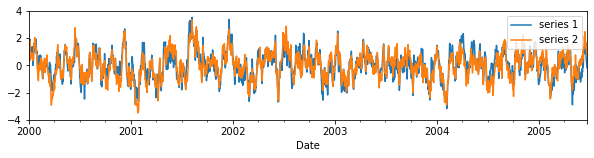

In [4]:
mt = metran.Metran(s)
series_std = mt.standardize(s)
series_std.plot(figsize=(10,2), xlabel='Date').set_ylim(-4, 4);

## 5. Running the model
Let us now run the model for the generate time series. In this example, we solve the model with `report=False`. This means that no report is shown. Instead, we analyze the results step by step.

In [5]:
mt = metran.Metran(s)
mt.solve(report=False)

INFO: Number of factors according to Velicer's MAP test: 0
INFO: Number of factors according to Kaiser criterion: 1


### 5.1 Factors, communality and specificity

Metran first determines the optimal number of common dynamic factors based on the correlation structure of the time series. For this, the Minimum Average Partial (MAP) test is used ([Velicer, 1976](#References); [Velicer et al., 2000](#References)). If this test results in 0 factors, then a second test is done based on the Kaiser criterion ([Kaiser, 1960](#References)). In this case, as we can see above, 1 factor has been selected to describe the common dynamics.

Besides, Metran estimates the factor loadings $\gamma_1$ and $\gamma_2$ using the minimum residual (minres) algorithm ([Harman and Jones, 1966](#References)).

In [6]:
print ('Factors:', mt.factors)

Factors: [[0.93540765]
 [0.93540765]]


As described in [section 3](#dfm), the factor loadings show the degree to which a factor elaborates a variable (observed series). The sum of squared factor loadings for all common factors for a given series is referred to as the communality. The communality measures the fraction of variance in a given variable explained by all common factors jointly, or in our case, one common factor.

In [7]:
print ('Communality:', mt.get_communality())

Communality: [0.87498746 0.87498746]


The fraction that is unique/specific for each series is referred to as the specificity and is calculated as (1 - communality).

In [8]:
print ('Specificity:', mt.get_specificity())

Specificity: [0.12501254 0.12501254]


### 5.2 Estimating AR(1) parameters
After the number of factors and associated factor loadings have been estimated, Metran uses an optimization algorithm to estimate the AR(1) model parameters $\phi_{s,1}$, $\phi_{s,2}$, and $\phi_{c}$. Similar to the AR parameter is `pastas`, $\phi$ is written as:

$$
\phi_k=e^{−\Delta t_i/\alpha_k}
$$

and $\alpha_k$ is being estimated. 

As all series have been standardized, the variance of each series is equal to 1. In addtion, we know the communality (and specificity) for each series, which means that we know the variance of the specific and common dynamic factors. As a result, the noise variance parameters of the AR(1) model do not need to be estimated. Instead, Metran calculates them as:

$$
\begin{align}
q_{s,1} &= \left(1-\phi_{s,1}^2\right) \cdot s_1 \\
q_{s,2} &= \left(1-\phi_{s,2}^2\right) \cdot s_2 \\
q_{c} &= \left(1-\phi_{c}^2\right)
\end{align}
$$

with $s_1$ and $s_2$ the specificity of series 1 resp. series 2.

The results of the parameter estimation process can be shown using `mt.fit_report()`.

In [9]:
print (mt.fit_report())

Fit report Cluster         Fit Statistics
tmin     None             obj     2262.45
tmax     None             nfev    64
freq     D                AIC     2268.45
solver   ScipySolve               

Parameters (3 were optimized)
              optimal   stderr initial  vary
sdf1_alpha   4.480130   ±5.97%      10  True
sdf2_alpha  19.343160  ±10.31%      10  True
cdf1_alpha   9.240526   ±3.11%      10  True

Parameter correlations |rho| > 0.5
None


### 5.3 Metran report
Further output of the Metran model parameters and statistics is given by `mt.metran_report()`. The following results are shown:
- nfct: number of factors
- fep: percentage of total variance explained by these factors
- communality for each series: percentage of variance that a series has in common with other series.
- state parameters:
 - AR(1) parameter $\phi$, calculated from the optimized parameter $\alpha$
 - variance $q$ of white noise process $\eta$
- observation parameters:
 - factor loadings $\gamma$ for each factor and series
 - scale: standard deviation $\sigma_n$ of each series (used for standardization, see [section 4](#standardization))
 - mean: mean $\mu_n$ of each series (used for standardization, see [section 4](#standardization))
- state correlations: correlation between specific and/or common dynamic factors

In [10]:
print (mt.metran_report())

Metran report Cluster        Factor Analysis
tmin     None                nfct    1
tmax     None                fep     93.61%
freq     D                            

Communality
                
series 1  87.50%
series 2  87.50%

State parameters
               phi         q
sdf1      0.799949  0.045015
sdf2      0.949616  0.012280
cdf1      0.897431  0.194617

Observation parameters
            gamma1     scale      mean
series 1  0.935408  4.769178 -0.847064
series 2  0.935408  4.928326 -0.868526

State correlations |rho| > 0.5
sdf1 sdf2 -0.6



The statistic `fep` is based on the eigenvalues of the correlation matrix. The eigenvalues can be retrieved from the `metran` class.

In [11]:
mt.eigval

array([1.87212635, 0.12787365])

The sum of the eigenvalues always equals the dimension of the correlation matrix, in this case 2.

In [12]:
round(mt.eigval.sum())

2

As we have used 1 eigenvalue (`nfct` = 1), the statistic `fep` is calculated as:

In [13]:
round(100 * mt.eigval[0] / mt.eigval.sum(), 2)

93.61

## 6. Checking the estimated AR(1) parameters
We can compare the estimate AR(1) parameters $\phi$ with the AR(1) parameters used to generate the time series.

In [14]:
print (np.round(np.diagonal(mt.get_transition_matrix()), 2), 'vs', phi)

[0.8  0.95 0.9 ] vs [0.8  0.95 0.9 ]


The estimated parameters are close to those being used to generate the synthetic series, which means that the model has estimated the autoregression of the latent components well.

## 7. Decomposition of series
The specific dynamic components (sdf's) $x_{s,1}$ and $x_{s,2}$ can be retrieved from the state vector $\mathbf{x}$. 

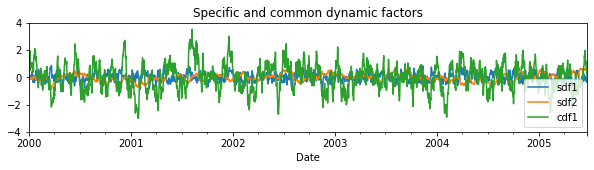

In [15]:
mt.get_state_means().plot(figsize=(10,2), 
                          xlabel='Date', 
                          title='Specific and common dynamic factors'
                         ).set_ylim(-4, 4);

Note that the common factor need to be multiplied by the factor loadings, to get the common factor for each series. Furthermore, these results are for the standardized series and need to be rescaled to obtain the unstandardized dynamic factors. Metran has a specific method to obtain the specific and common dynamic factors for each series.

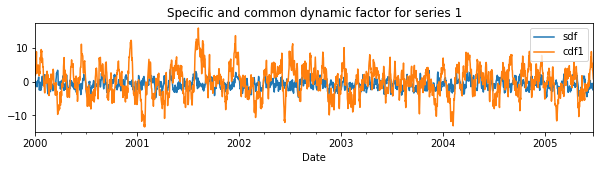

In [16]:
mt.decompose_simulation(name='series 1').plot(
    figsize=(10,2), xlabel='Date', 
    title='Specific and common dynamic factor for series 1');

We can compare the calculated specificity with the variance of the specific dynamic component divided by the series variance (which is the sum of the specific and common dynamic factor).

In [17]:
sim1 = mt.decompose_simulation(name='series 1')
sdf1_variance = sim1['sdf'].var() / sim1.sum(axis=1).var()
print ('Variance sdf series 1:', "{:.2f}%".format(100 * sdf1_variance))
print ('Specificity series 1 :', "{:.2f}%".format(100 * mt.get_specificity()[0]))

Variance sdf series 1: 8.52%
Specificity series 1 : 12.50%


Theoretically, these values must be equal. In practice, they may slightly differ, e.g. due to some correlation between the specific and common dynamic factor. We can test this by calculating the correlation.

In [18]:
sim1.corr()

,sdf,cdf1
sdf,1.000000,0.162149
cdf1,0.162149,1.000000


Similar to series 1, we can decompose series 2 and compare the associated specificity and communality.

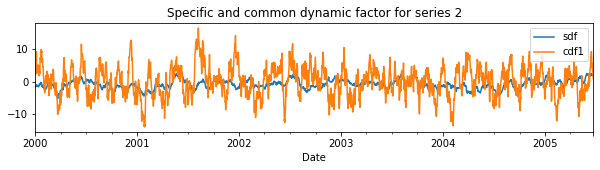

In [19]:
mt.decompose_simulation(name='series 2').plot(
    figsize=(10,2), xlabel='Date',
    title='Specific and common dynamic factor for series 2');

In [20]:
sim2 = mt.decompose_simulation(name='series 2')
sdf2_variance = sim2['sdf'].var() / sim2.sum(axis=1).var()
print ('Variance sdf series 2:', "{:.2f}%".format(100 * sdf2_variance))
print ('Specificity series 2 :', "{:.2f}%".format(100 * mt.get_specificity()[1]))

Variance sdf series 2: 7.48%
Specificity series 2 : 12.50%


In [21]:
sim2.corr()

,sdf,cdf1
sdf,1.000000,0.193684
cdf1,0.193684,1.000000


## References
Berendrecht, W.L., F.C. van Geer, 2016. A dynamic factor modeling framework for analyzing multiple groundwater head series simultaneously, Journal of Hydrology, 536, pp. 50-60, [doi:10.1016/j.jhydrol.2016.02.028][Ber2016].

[Ber2016]: http://dx.doi.org/10.1016/j.jhydrol.2016.02.028 "Journal of Hydrology"

Harman, H., Jones, W., 1966. Factor analysis by minimizing residuals (minres). Psychometrika 31, 351–368.

Kaiser, H.F., 1960. The application of electronic computers to factor analysis. Educ. Psychol. Meas. 20, 141–151.

Velicer, W.F., 1976. Determining the number of components from the matrix of partial correlations. Psychometrika 41, 321–327.

Velicer, W.F., Eaton, C.A., Fava, J.L., 2000. Construct explication through factor or component analysis: a review and evaluation of alternative procedures for determining the number of factors or components. In: Goffin, R., Helmes, E. (Eds.), Problems and Solutions in Human Assessment. Springer, US, pp. 41–71.
